# FCAL LED Gain System Simulation Analysis

This contains some analysis of a simple FCAL gain simulation data set produced by Mike Goodrich for trying to understand how to extract gain factors from the data and what the limitations are.

The simulation consisted of 50 FCAL blocks where the amplitudes of each block are given by:


$$
A_{i} = \alpha g_{i}\omega_{i} \tag{1}
$$

where:

$A_{i}$ = amplitude for PMT $i$ read by DAQ             <br>
$\alpha$ = LED amplitude (common to all channels)       <br>
$g_{i}$ = gain for PMT $i$                              <br>
$\omega$ = optical coupling of PMT $i$ to LED (=1 here) <br>


For the simulation, the $\alpha$ was determined by a regular sawtooth function. The $g_{i}$ values were taken as the sum of at least two sine waves (centered on 1) with amplitudes, frequencies, and phases randomly sampled. The $\omega_{i}$ values were randomly sampled once and remained static for all time steps of the simulation.

Mike focused on a single channel, $g_{17}$ for much of his studies (see Slack) so that same channel is used here.


In [1]:
# Read dataset into dataframe. This file was sent to me by Mike via e-mail on 2023-08-19
# This will rename the columns to use the "A" notation instead of the "b" notation in the file.
# It will also add an alpha column.

import pandas as pd

filename = '/work/epsci/davidl/2023.08.18.AIEC_LSTM_simulation/fcal2.csv'

df = pd.read_csv(filename)

# Rename columns from "bX" to "AX" to better align with what we say vocally
name_map = {}
for i in range(1,51):
    name_map['b'+str(i)] = 'A'+str(i)
df = df.rename(columns=name_map)

# Calculate alpha (should work for any pair)
df['alpha'] = df['A17']/df['g17']

### Plot $A_{17}$, $g_{7}$ and $\alpha$



<Axes: >

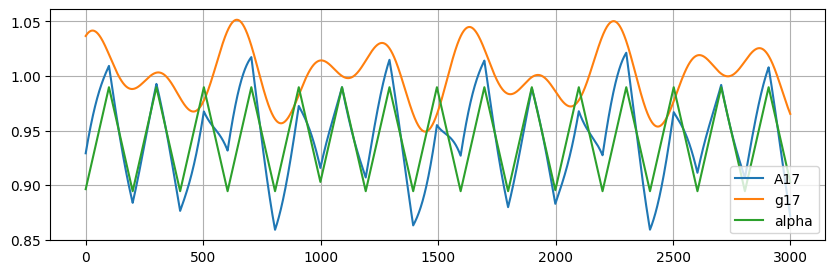

In [2]:
import matplotlib.pyplot as plt

df.plot(y=["A17", "g17", "alpha"], kind="line", grid=True, figsize=(10,3))

### Estimate $\alpha$

Make an estimate of the value of $\alpha$ at each time step by taking simple average of all "A"s. The idea is that the "g"s are uncorrelated and will average to 1.

$$
\alpha_{est} = \frac{1}{50}\sum_{i=1}^{50} A_{i} =  \frac{1}{50}\sum_{i=1}^{50} \alpha g_{i} = \alpha\frac{1}{50}\sum_{i=1}^{50} g_{i} = \alpha\times(\approx 1)
\tag{2}
$$

The plot below shows the calculated $\alpha$ (using truth info.) and the estimated $\alpha$ (using only features). Two things to note:

1. The estimated value $\alpha_{est}$ is about 0.0478 ($\approx 5$%) higher than the true value of $\alpha$

2. The true $\alpha$ is not perfect, at least visually in the plot (see minimum at x=1000). 


alpha_avg=0.9425778724148947  alpha_est_avg=0.9903998267986364  (diff=0.047821954383741705)


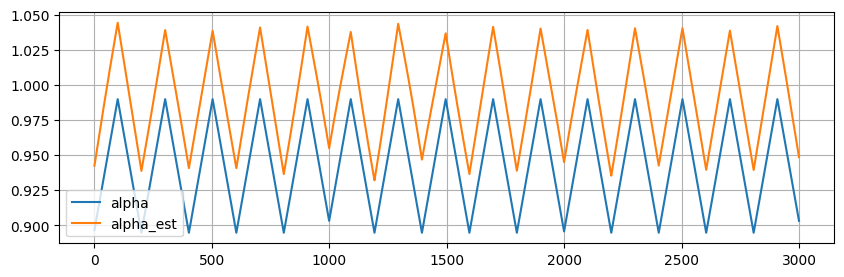

In [3]:
# Estimate \alpha by averaging "A"s. Plot true and estimated \alpha
df['alpha_est'] = df.filter(like="A").mean(axis=1)
df.plot(y=["alpha", "alpha_est"], kind="line", grid=True, figsize=(10,3))

# Calculate averages and print them
alpha_avg = df['alpha'].mean()
alpha_est_avg = df['alpha_est'].mean()
print('alpha_avg={}  alpha_est_avg={}  (diff={})'.format(alpha_avg, alpha_est_avg, alpha_est_avg-alpha_avg))

### Estimate $g_{17}$

The value of $g_{i}$ can be estimated by dividing the measured $A_{i}$ by the estimated $\alpha_{est}$.

The top plot shows the true $g_{17}$ (blue) and the estimated $g_{17}$ (orange). This shows the estimated value of g17 is scaled down a bit from the true value. This is because alpha is larger than the true value. 

The next plot shows both the difference and ratio of the estimated $\alpha_{est}$ and the true $\alpha$. Note that the ratio has 1 subtracted to shift it to align with the difference for easier visual comparison.


<Axes: >

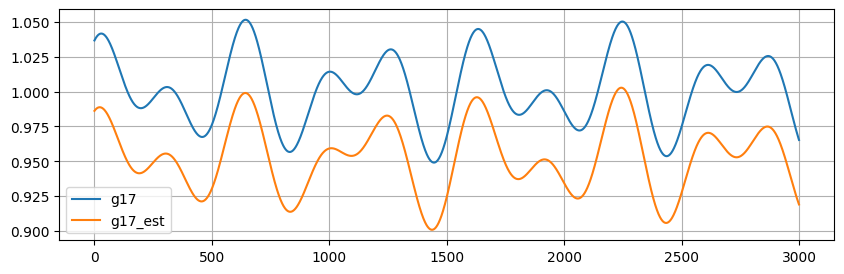

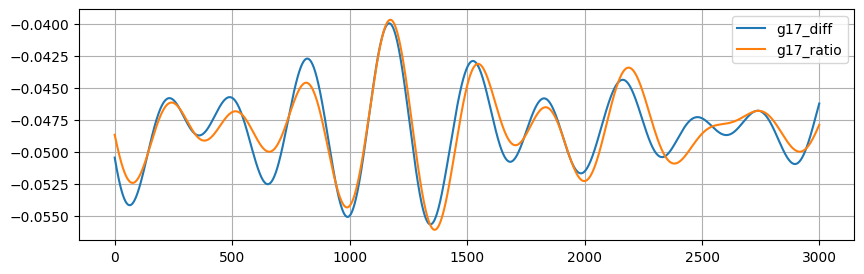

In [4]:
df["g17_est"] = df["A17"]/df["alpha_est"]
df.plot(y=["g17", "g17_est"], kind="line", grid=True, figsize=(10,3))

df["g17_diff" ] = (df["g17_est"] - df["g17"])
df["g17_ratio"] = df["g17_est"] / df["g17"] - 1.0
df.plot(y=["g17_diff", "g17_ratio"], kind="line", grid=True, figsize=(10,3))

### Correction to $g_{17}$

Here I assume that the values of $A_{i}$ and $\alpha$ are not drifting over a long time scale (e.g. the whole data set). The real assumption is that the ratio of the average value of $A_{i}$ to the average value of $\alpha$ over a long period of time is constant. This allows this ratio to be used to estimate a correction factor for the $g_{i}$. For $g_{17}$ this is $\approx 1.049$.

The top plot below shows $g_{17}$ and $g_{17}$ corrected by this factor.

The next plot shows the difference between these.


g17_scale = 1.0493750275203033


<Axes: >

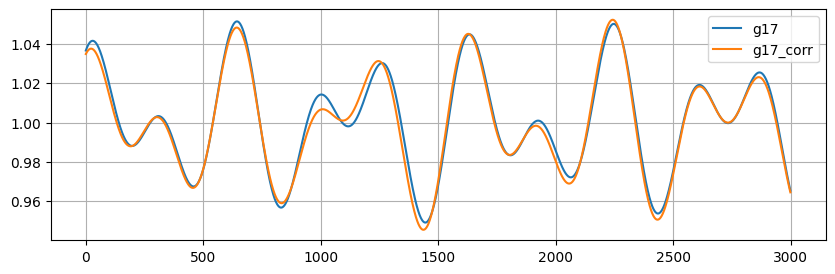

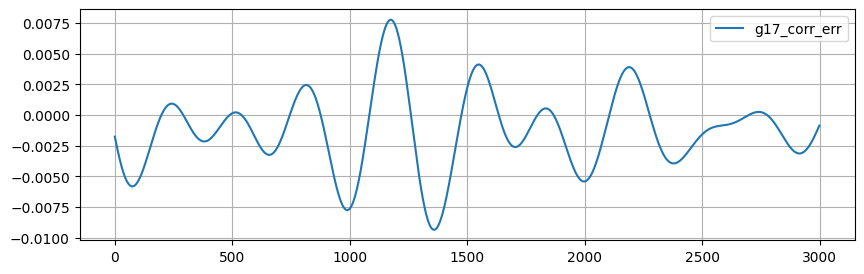

In [5]:
g17_scale = df["alpha_est"].mean()/df["A17"].mean()
print('g17_scale = {}'.format(g17_scale))

df["g17_corr"] = df["g17_est"] * g17_scale
df.plot(y=["g17", "g17_corr"], kind="line", grid=True, figsize=(10,3))

df["g17_corr_err"] = df["g17_corr"] - df["g17"]
df.plot(y=["g17_corr_err"], kind="line", grid=True, figsize=(10,3))

## Estimate $g_{37}$

Here, the above procedure is repeated for $g_{37}$ but with these differences:

1. The values of $\alpha_{est}$ are still derived from $A_{17}$. This means the $\alpha_{est}$ used here is derived from an independent channel which should eliminate the potential of a result being too good due to an unknown self-referencing effect.

2. Only the first 2000 of the 3000 time steps were used to derive the final correction factor. This makes the last 1000 time steps more predictive.

g37_scale = 0.9527204208559328
ERROR RMS: 0.0031800255403150015


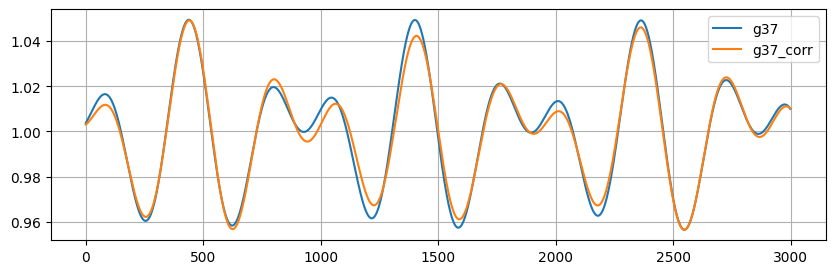

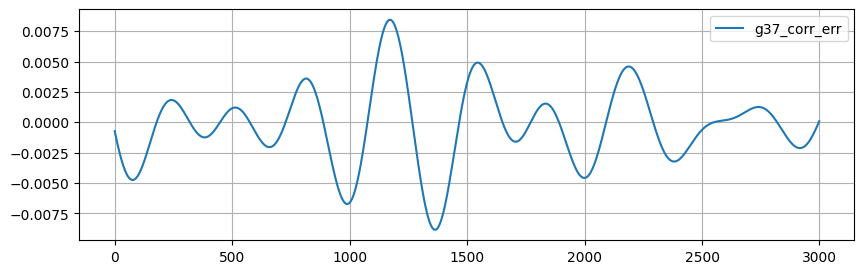

In [6]:
Nsteps_for_mean = 2000
df["g37_est"] = df["A37"]/df["alpha_est"]
g37_scale = df["alpha_est"].values[:Nsteps_for_mean].mean()/df["A37"].values[:Nsteps_for_mean].mean()
print('g37_scale = {}'.format(g37_scale))

df["g37_corr"] = df["g37_est"] * g37_scale
df.plot(y=["g37", "g37_corr"], kind="line", grid=True, figsize=(10,3))

df["g37_corr_err"] = df["g37_corr"] - df["g37"]
df.plot(y=["g37_corr_err"], kind="line", grid=True, figsize=(10,3))

rms = df.std()["g37_corr_err"]
print('ERROR RMS: {}'.format(rms))

# Conclusion

This indicates that, for the ideal conditions of this simulation, it is possible to estimate an individual block's gain from only the $A_{i}$ values.

The error has a $\sigma$ of $\approx 0.32$% with a maximum of $\approx \pm 0.80$%.<br>
*(n.b. The region of x>2000 actually has smaller errors on average AND constitutes the prediction region where one might expect the errors to be larger!?)*